## Generate Mock Data

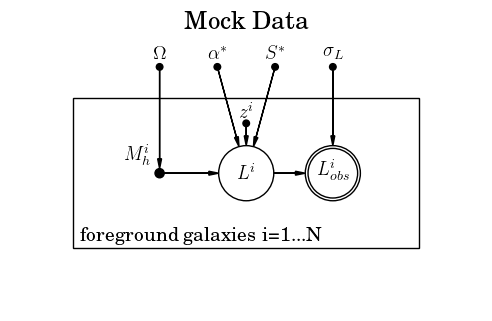

In [1]:
from IPython.display import Image
Image(filename='pgm_mock_data.png')

The distributions are 

\begin{align*}
P(L^i|\alpha^*, S^*, M_h^i, z^i) &= \text{Lognormal}(\mu_L^i, S^*)\\
\mu_L^i &= \alpha_1^* + \alpha_2^* \ln(M_h^i/\alpha_3^*) + \alpha_4^*(1+z^i)\\
P(L^i_{obs}|L^i) &= \text{Lognormal}(L^i, \sigma_L)\\
\end{align*}

The mass-luminosity parameters from Reddick's thesis [1]:

\begin{align*}
\alpha_1 &= \ln L_{c0} &= 10.709^{+0.021}_{-0.023} \log L_{\odot} / h^2\\
\alpha_2 &= A_L &= 0.359\pm 0.009\\
\alpha_3 &= M_{piv} &= 2.35 \times 10^{14} M_{\odot}\\
\alpha_4 &= B_L &= 1.10 \pm 0.06\\
S &= \sigma_L &= 0.155 \pm 0.009 \log L_{\odot}/h^2\\
\end{align*}

We fix $\sigma_L \sim S / 3 \sim 0.05$. Now we draw a random assortment of $\alpha, S$ from normal distributions characterized by Reddick's numbers:

In [2]:
from scipy.stats import norm
import numpy as np

np.random.seed(1)

alpha1 = norm(10.709, 0.022).rvs()
alpha2 = norm(0.359, 0.009).rvs()
alpha3 = 2.35e14
alpha4 = norm(1.10, 0.06).rvs()
S = norm(0.155, 0.0009).rvs()
sigma_L = 0.05

print ' alpha1 = {}\n alpha2 = {}\n alpha3 = {}\n alpha4 = {}\n S = {}\n sigma_L = {}'\
    .format(alpha1, alpha2, alpha3, alpha4, S, sigma_L)

 alpha1 = 10.744735598
 alpha2 = 0.353494192277
 alpha3 = 2.35e+14
 alpha4 = 1.06830969486
 S = 0.15403432824
 sigma_L = 0.05


Next we load data from the Millennium Simulation and extract a $60 \times 60 \text{ arcmin}^2$ field of view.

In [3]:
import pandas as pd
from massinference.angle import Angle

# opening, white-listing, renaming
usecols = ['GalID', 'pos_0[rad]', 'pos_1[rad]', 'M_Subhalo[M_sol/h]', 'z_spec']
guo = pd.read_table(
    '/Users/user/Code/Pangloss/data/GGL_los_8_0_0_0_0_N_4096_ang_4_Guo_galaxies_on_plane_27_to_63.images.txt', 
    usecols=usecols)
guo.rename(
    columns={'GalID': 'gal_id',
             'M_Subhalo[M_sol/h]': 'mass_h',
             'z_spec': 'z'
            }, 
    inplace=True)
guo = guo[guo['mass_h'] > 0]

guo['mass_h'] = guo['mass_h'] * 0.73 #remove h^{-1} from mass units, use h from WMAP

# convert to arcmin
guo['ra'] = Angle.radian_to_arcmin(guo['pos_0[rad]'])
guo['dec'] = Angle.radian_to_arcmin(guo['pos_1[rad]'])

# field of view bounds
ra_i = guo['ra'].min()
dec_i = guo['dec'].min()
ra_f = ra_i + 40
dec_f = dec_i + 40
z_i = guo['z'].min()
z_f = guo['z'].max()

# clip data, fov = field of view
fov = guo[(guo['ra'] >= ra_i)
           & (guo['ra'] < ra_f)
           & (guo['dec'] >= dec_i)
           & (guo['dec'] < dec_f)].copy(deep=True)

fov.drop(['pos_0[rad]', 'pos_1[rad]'], axis=1, inplace=True)

In [4]:
fov.columns

Index([u'gal_id', u'z', u'mass_h', u'ra', u'dec'], dtype='object')

Finally we sample luminosity and observed luminosity with the hyperparameters we drew above. Then we save the dataset.  

In [10]:
from scipy.stats import lognorm

mu_lum = np.exp(alpha1 + alpha2 * np.log(fov.mass_h / alpha3) + alpha4 * (1 + fov.z))
lum = lognorm(S, scale=mu_lum).rvs()
lum_obs = lognorm(sigma_L, loc=lum).rvs()

fov['lum'] = lum
fov['lum_obs'] = lum_obs

fov.to_csv('mock_data.csv')

## Mass Prior

First we find the min and max halo mass over the whole healpix of the Millennium Survey [2].

In [6]:
from math import log

# NOTE: hmf uses units of M_{\odot}/h for mass
h = 0.73

Mmin = log((guo['mass_h'] / h).min()) / log(10)
Mmax = log((guo['mass_h'] / h).max()) / log(10)

print ' Mmin = {}\n Mmax = {}'\
    .format(Mmin, Mmax)

 Mmin = 10.2358590918
 Mmax = 14.3277327776


Next we use the python package hmf [3] to get the mass function (Tinker 2010) for our cosmology (WMAP).

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import rc
import hmf
from scipy.stats import rv_discrete
import scipy.interpolate as interpolate

rc('text', usetex=True)

mf = hmf.MassFunction(Mmin=Mmin, Mmax=Mmax, cosmo_model=hmf.cosmo.WMAP5, hmf_model=hmf.fitting_functions.Tinker10)
pdf = mf.dndm / sum(mf.dndm)
cum_values = np.cumsum(pdf)
inv_cdf = interpolate.interp1d(cum_values, mf)

plt.figure(figsize=(8,4))

plt.subplot(311)
plt.ylabel('Density')
plt.hist(np.log(fov.mass_h) / np.log(10), alpha=0.5, normed=True, label='millennium')
plt.plot(np.log(mf.m * h) /np.log(10), 50*pdf, color='red', label='hmf')
plt.legend()

plt.subplot(312)
plt.ylabel('Density')
ms_mass = np.log(fov.mass_h) / np.log(10)
ms_mass_cut = ms_mass[ms_mass >= 11.]
plt.hist(ms_mass_cut, alpha=0.5, normed=True, label='millennium')
cut_ind = 90
m_cut = (np.log(mf.m * h) /np.log(10))[cut_ind:]
pdf_cut = (1.85e3*pdf)[cut_ind:]
plt.plot(m_cut, pdf_cut, color='red', label='hmf')
plt.legend()

plt.subplot(313)
plt.xlabel('$\log_{10}M_{\odot}$')
plt.ylabel('Density')
ms_mass = np.log(fov.mass_h) / np.log(10)
ms_mass_cut = ms_mass[ms_mass >= 12.]
plt.hist(ms_mass_cut, alpha=0.5, normed=True, label='millennium')
cut_ind = 190
m_cut = (np.log(mf.m * h) /np.log(10))[cut_ind:]
pdf_cut = (2e5*pdf)[cut_ind:]
plt.plot(m_cut, pdf_cut, color='red', label='hmf')
plt.suptitle('PDF Cut Overlays')
plt.legend()

ValueError: x and y arrays must be equal in length along interpolation axis.

The issue here is that the hmf distribution does not match the mass distribution from the millennium simulation. This makes sense for the bottom end of our mass range where there are likely many halos on the edge that the halo finder failed to recognize. The part that I am more concerned about is that the decay as we move to high mass is MUCH greater in the halo mass function than we see from the dataset.

In [8]:
import scipy.interpolate as interpolate

class MassPrior():
    def __init__(self, mass, prob):
        self.mass = mass
        self.prob = prob
        self.min = mass.min()
        self.max = mass.max()
        # have to add 0,1 samples for interpolation bounds
        cumsum = np.append(np.append(np.array([0]), np.cumsum(prob)), np.array([1]))
        masses = np.append(np.append(np.array([self.min-1]), self.mass), np.array([self.max+1]))
        self.inv_cdf = interpolate.interp1d(cumsum, masses)

        
    def pdf(self, mass):
        if np.any(mass < self.min) or np.any(mass > self.max):
            raise Exception('out of range')
        right_ind = np.searchsorted(self.mass, mass)
        left_ind = right_ind - 1
        # find where we fall in interval between masses
        f = (mass - self.mass[left_ind]) / (self.mass[right_ind] - self.mass[left_ind])
        return f * self.prob[right_ind] + (1-f) * self.prob[left_ind]
        
    def rvs(self, *args, **kwargs):
        return self.inv_cdf(np.random.rand(size))

## Bias Distribution Test

See [Proposal](Proposal_2017_01_10.ipynb) for more information on the biased distribution we use for importance sampling. Below we compare the numerator in our likelihood integrand, $P(L_{obs}^i| L^i)P(L^i|\alpha^*, S^*, M_h^i, z^i)P(M_h^i)$ when sampled from $P(M_h)$ and when sampled from $Q(M_h,L)$.

In [440]:
from scipy.stats import lognorm

mp = MassPrior(mf.m*h, mf.dndm / sum(mf.dndm))

def log_P_m(mass_h):
    return np.log(mp.pdf(mass_h))
    
def log_P_l_given_m_z(mass_h, z, lum):
    mu_l = alpha1 + alpha2 * np.log(mass_h / alpha3) + alpha4 * (1+z)
    return lognorm(S, loc=mu_l).logpdf(lum)
    
def log_P_lobs_given_l(lum, lum_obs):
    return lognorm(sigma_L, loc=lum).logpdf(lum_obs)

def log_weight(mass_h, lum, lum_obs, z):
    print log_P_m(mass_h)
    print log_P_l_given_m_z(mass_h, z, lum)
    print log_P_lobs_given_l(lum, lum_obs)
    return log_P_m(mass_h) + log_P_l_given_m_z(mass_h, z, lum) + log_P_lobs_given_l(lum, lum_obs)

def draw_m(size):
    return mp.rvs(size=size)

def draw_lobs_given_l(lum):
    return lognorm(sigma_L, loc=lum).rvs()

def draw_l_given_m_z(m, z):
    mu_l = np.exp(alpha1 + alpha2 * np.log(m / alpha3) + alpha4 * (1+z))
    return lognorm(S, loc=mu_l).rvs()    

To test our biased importance sampling distribution we randomly draw new hyperparameters.

In [441]:
np.random.seed(2)

alpha1b = norm(10.709, 0.022).rvs()
alpha2b = norm(0.359, 0.009).rvs()
alpha3b = 2.35e14
alpha4b = norm(1.10, 0.06).rvs()
Sb = norm(0.155, 0.0009).rvs()
sigma_Lb = 0.05

print ' alpha1b = {}\n alpha2b = {}\n alpha3b = {}\n alpha4b = {}\n Sb = {}\n sigma_Lb = {}'\
    .format(alpha1b, alpha2b, alpha3b, alpha4b, Sb, sigma_Lb)

 alpha1b = 10.6998313274
 alpha2b = 0.358493598555
 alpha3b = 2.35e+14
 alpha4b = 0.97182823426
 Sb = 0.156476243728
 sigma_Lb = 0.05


In [442]:
data = pd.read_csv('mock_data.csv')

def draw_biased_m_l(lobs, z):
    l = lognorm(sigma_Lb, loc=lobs).rvs()
    mu_m = alpha3b * (l / (np.exp(alpha1b) * (1 + z) ** alpha4b)) ** (1 / alpha2b)
    m = lognorm(Sb, loc=mu_m).rvs()  
    return (m,l)

In [447]:
nsamples = 100

# data
z_data = data['z'].as_matrix()[0:nsamples]
lobs_data = data['lum_obs'].as_matrix()[0:nsamples]

# biased samples
m_biased, l_biased = draw_biased_m_l(lobs_data, z_data)

# unbiased samples
m = draw_m(nsamples)
l = draw_l_given_m_z(m, z_data)


log_weight(m[0], l_biased[0], lobs_data[0], z_data[0])

-3.72509689076
-2696.39035571
-inf


-inf

## Questions
- Reddick's function fits the luminosity of centrals. Should we be worried about using it in our case for subhalos?
- What should we do about mass function vs millennium mass distribution?

## References

[1] Rachel Marie Reddick. ReddiCosmology and galaxy formation using the galaxy-halo connection to probe cosmology. https://searchworks.stanford.edu/view/10531737. 2014.

[2] V. Springel, S. D. M. White, A. Jenkins, C. S. Frenk, N. Yoshida, L. Gao, J. Navarro, R. Thacker, D. Croton, J. Helly, J. A. Peacock, S. Cole, P. Thomas, H. Couchman, A. Evrard, J. Colberg, and F. Pearce. Simulations of the formation, evolution and clustering of galaxies and quasars. http://www.nature.com/nature/journal/v435/n7042/full/nature03597.html. 2005.

[3] Steven Murray, Chris Power, Aaron Robotham . HMFcalc: An Online Tool for Calculating Dark Matter Halo Mass Functions. https://arxiv.org/abs/1306.6721. 2013.